In [20]:
import time
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.coordinates import ICRS, Galactic, FK4, FK5

keyin_file = "0711.txt"
start = "2021.07.23 00:00:00"
end = "2021.07.23 4:59:59"

In [25]:
def getPsrName(array):
    if("3C" in array["source"]):
        return array["source"].replace("'", "").replace('"', "")
    return "PSR" + array["source"].replace("'", "").replace('"', "")

def sorting_rewrite(array):
    listForSorting = list()
    for i in range(len(array)):
        listForSorting.append([i, array[i]["rises"][0][0]])
        
    listForSorting = sorted(listForSorting, key=lambda x:x[1])
    for i in range(len(listForSorting)):
        listForSorting[i] = array[listForSorting[i][0]]

    return listForSorting

def hours_plus(time1, time2):
    time0 = time1 + time2
    while(time0 > 24):
        time0 = time0 - 24
    
    return time0

def gen_axis(start, hours, gap=2):
    axis = []
    added_hours = 0
    while(hours > added_hours):
        added_hours = added_hours + gap
        axis.append(hours_plus(start, added_hours))
    
    return axis

# 绘制图像
def psr_plot(loadedKey):
    PSRS = list()
    loadedKey = compute_durs(loadedKey)
    for key in range(len(loadedKey)):
        value = loadedKey[key]
        #print(loadedKey[key]["source"])
        star_name = getPsrName(loadedKey[key])
        # print(star_name)
        skyCo = SkyCoord.from_name(star_name.replace("'", ""))
        transformed = skyCo.transform_to(altazframe)
        PSRS.append(skyCo)
        # print(skyCo)

        plt.scatter(delta_midnight[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))], transformed.alt[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))], label=star_name,lw=0,s=5)
        #print(transformed.alt[1:3])
        #print(delta_midnight[math.floor(1000*(value["dur_started"]/86400)):math.floor(1000*(value["dur_ended"]/86400))])
        #plt.plot(delta_midnight[value["dur_started"]:value["dur_ended"]],PSR_B0329altazs[value["dur_ended"]:value["dur_ended"]].alt, c='b', label='PSR B0329+54' )

    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.xlim(0, 0.7*24)
    plt.xticks(np.arange(13)*2)
    #plt.xticks(gen_axis(int(abs_start_hours), durations/60/60))
    #print(gen_axis(int(abs_start_hours), durations/60/60))
    plt.ylim(0, 90)
    plt.xlabel('Hours from UTC '+ time.strftime("%Y-%m-%d %H:%M:%S", time.strptime(start, "%Y.%m.%d %H:%M:%S")))
    plot = plt.ylabel('Altitude [deg]')
    plt.show()
    
    return True

def psr_load(keyin_file):
    abs_start_hours = (time.strftime("%H", time.strptime(start, "%Y.%m.%d %H:%M:%S")))
    matrix_raw = np.loadtxt(open(keyin_file,"r"),delimiter=None, dtype=str, converters=None, skiprows=0)  
    shape_raw = matrix_raw.shape
    
    keyLocats =[[0, 2], [3, 5], [6, 8], [9, 11]]
    loadedKey = list()
    for a in range(shape_raw[0]):
        #loadedKey[a] = dict()
        loadedKey.append(dict())
        for keyLoc in keyLocats:
            loadedKey[a][matrix_raw[a, keyLoc[0]]] = matrix_raw[a, keyLoc[1]]
        
    return loadedKey

def compute_durs(importedKey):
    durations = 0
    for a in range(len(importedKey)):
        #loadedKey[a] = dict()
        importedKey[a]["dur_started"] = durations
        
        durations = durations + int(importedKey[a]['dur']) + int(importedKey[a]['gap'])
                
        importedKey[a]["dur_ended"] = durations
    
    return importedKey
    
def coord(psrName, retList = False):
    skyCo = SkyCoord.from_name(psrName)
    if(retList == False):
        return skyCo
    
    skyCo = skyCo.to_string().split(" ")
    skyCo[0] = float(skyCo[0])
    skyCo[1] = float(skyCo[1])
    
    return skyCo

def gap_between(key1, key2, velocity = [.05, .067]):
    key1_coord = coord(getPsrName(key1), True)
    key2_coord = coord(getPsrName(key2), True)
    dCoord = [abs(key1_coord[0] - key2_coord[0]), abs(key1_coord[1] - key2_coord[1])]
    tCoord = [dCoord[0]/velocity[0], dCoord[1]/velocity[1]]
    print(tCoord)
    return max(tCoord)

def Timestamp(timestamp):
    return Time(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

def riseTime(psrName, location, begin, end, gap = 500):
    lastAlt = -1
    rised = -1
    rises = list()
    for i in range(int((end-begin)/gap)):
        begin = begin + gap
        Timestamp(begin)
        thisAlt = float(coord(psrName).transform_to(AltAz(obstime=Timestamp(begin), location=shanghai)).to_string().split(" ")[1])
        
        if(lastAlt < 20 and thisAlt > 20):
            rised = begin
        elif(lastAlt > 20 and thisAlt < 20):
            rises.append([rised, begin])
            rised = -1
            
        lastAlt = thisAlt
    
    if(rised != -1):
        rises.append([rised, begin])
    
    if(len(rises) <= 0):
        rises.append([end+1, end+1])
    
    return rises

def if_observable(start, end, array):
    star_name = getPsrName(array)
    observable = True
    
    rises = array['rises']
    for rise in rises:
        rise_obs = False
        if(rise[0] <= start and rise[1] >= end):
            rise_obs = True
    if(rise_obs != True):
        observable = False
    
    return observable

def shortest_rise(array):
    shortest = False
    shortestlen = -1
    for i in range(len(array)):
        thisRiseLen = 0
        for a in range(len(array[i]["rises"])):
            thisRiseLen = thisRiseLen + array[i]["rises"][a][1] - array[i]["rises"][a][0]
            
        if(thisRiseLen < shortest or thisRiseLen == -1):
            shortest = i
            shortestlen = thisRiseLen
    
    return shortest
      
def nearest_sorting(importedKey):
    newList = list()
    impList = copy.deepcopy(importedKey)
    
    first = smallestRA(loadedKey)
    newList = [impList[first]]
    del impList[first]
    while(len(impList) > 0):
        nextPsr = nearest(impList, len(impList)-1)
        newList.append(impList[nextPsr])
        del impList[nextPsr]
    
    return newList

def nearest(importedKey, k, farest = False):
    lastRA = -1
    lastDec = -1
    distKey = list()
    star_name = getPsrName(importedKey[k])
    skyCo = SkyCoord.from_name(star_name.replace("'", ""))
    sourceRA = float(skyCo.to_string().split(" ")[0])
    sourceDec = float(skyCo.to_string().split(" ")[1])
    
    testKey = [list(), list()]
    nearestKey = [0, False]
    for i in range(len(importedKey)):
        if(i != k):
            star_name = getPsrName(importedKey[i])
            skyCo = SkyCoord.from_name(star_name.replace("'", ""))
            thisRA = float(skyCo.to_string().split(" ")[0])
            thisDec = float(skyCo.to_string().split(" ")[1])
            dDist = math.sqrt(abs(thisRA - sourceRA)**2 + abs((thisDec - sourceDec))**2)
            
            if(nearestKey[0] > dDist or nearestKey[1] == False):
                nearestKey = [dDist, i]
                testKey[0].append(thisRA)
                testKey[1].append(thisDec)
    
    if(farest):
        nearestKey = [0, False]
        for i in range(len(importedKey)):
            if(i != k):
                star_name = getPsrName(importedKey[i])
                skyCo = SkyCoord.from_name(star_name.replace("'", ""))
                thisRA = float(skyCo.to_string().split(" ")[0])
                thisDec = float(skyCo.to_string().split(" ")[1])
                dDist = math.sqrt(abs(thisRA - sourceRA)**2 + abs((thisDec - sourceDec))**2)

                if(nearestKey[0] < dDist or nearestKey[1] == False):
                    nearestKey = [dDist, i]
        
        return nearestKey[1]
    
    return nearestKey[1]

def sortedbyRA(importedKey, listi = False):
    listForSorting = list()
    for i in range(len(importedKey)):
        star_name = getPsrName(importedKey[i])
        skyCo = SkyCoord.from_name(star_name.replace("'", ""))
        thisRA = float(skyCo.to_string().split(" ")[0])
        thisDec = float(skyCo.to_string().split(" ")[1])
        
        listForSorting.append([i, thisRA])
    
    sortedList = list()
    listForSorting = sorted(listForSorting, key=lambda x:x[1])
    if(listi):
        return listForSorting
    
    for i in range(len(listForSorting)):
        sortedList.append(importedKey[listForSorting[i][0]])
    
    return sortedList

def smallestRA(importedKey):
    return sortedbyRA(importedKey, True)[0][0]
        
def previewKey(importedKey):
    psr_plot(importedKey)
    #print(importedKey)
    #for i in range(len(importedKey)):
    #    print(importedKey[i]['source'])
    print("##################\n## KEY EXPORTED ##\n##################")
    print(saveAsKeyinFile(importedKey))

def saveAsKeyinFile(importedKey, filename = False):
    keyinFile = ""
    for i in range(len(sortedKey)):
        keyinFile = keyinFile + "source = "+sortedKey[i]['source']+"		dur = "+sortedKey[i]['dur']+"	gap = "+str(int(sortedKey[i]['gap']))+" setup = 'pfb20cm2'	/" + "\n" 
    
    if(filename != False):
        open(filename, "w+").write(keyinFile)
        
    return keyinFile

def monitoring_txt(filename):
    auto = False
    while(1):
        psr_plot(psr_load(filename))
        
        if(auto):
            time.sleep(1)
        else:
            cmd = input("[scheduller] > ")
            if(cmd == "exit"):
                break
            elif(cmd == "auto"):
                auto = True
                
#sortedbyRA(loadedKey)
#smallestRA(loadedKey)
#riseTime("PSR J1809-1943", shanghai, startTimestamp, endTimestamp, gap = 599)
#sortedbyRA(psr_load(keyin_file), True)

In [26]:
startTimestamp = time.mktime(time.strptime(start, "%Y.%m.%d %H:%M:%S"))
endTimestamp = time.mktime(time.strptime(end, "%Y.%m.%d %H:%M:%S"))
loadedKey = psr_load(keyin_file)
shanghai = EarthLocation(lat=31*u.deg, lon=121.9*u.deg, height=10*u.m)
midnight = Time(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(startTimestamp)))
delta_midnight = np.linspace(0, 24, 1000)*u.hour
times = midnight + delta_midnight
altazframe = AltAz(obstime=times, location=shanghai)

#print(loadedKey)
#loadedKey = nearest_sorting(loadedKey)
loadedKey = sortedbyRA(loadedKey)
for i in range(len(loadedKey)):
    psrName = (getPsrName(loadedKey[i])).replace("'", "")
    print("[PROCESSING] " + psrName)
    loadedKey[i]['rises'] = riseTime(psrName, shanghai, startTimestamp, endTimestamp)

#previewKey(loadedKey)

[PROCESSING] PSRJ1713+0747
[PROCESSING] PSRJ1809-1943
[PROCESSING] PSRJ1818-1607
[PROCESSING] PSRJ1935+2154


In [23]:
search_gap = 1
nowTime = startTimestamp
procedKey = copy.deepcopy(sorting_rewrite(loadedKey))
sortedKey = list()
while(nowTime < endTimestamp):
    if(len(procedKey) <= 0):
        break
    
    thisSched = False
    
    for i in range(len(procedKey)):
        thisprocedKey = procedKey[i]
        thisDur = float(thisprocedKey['dur'])
        
        if(if_observable(nowTime, nowTime + thisDur, thisprocedKey)):
            #print(thisprocedKey["source"])
            #sortedKey.append(thisprocedKey)
            #nowTime = nowTime + thisDur
            #del procedKey[i]
            thisSched = [i, thisDur]
            #print(procedKey)
            break
    
    shortestRisekeyi = shortest_rise(procedKey)
    if(if_observable(nowTime, nowTime + float(procedKey[shortestRisekeyi]['dur']), procedKey[shortestRisekeyi])):
        #print(procedKey[shortestRisekeyi]["source"])
        #sortedKey.append(procedKey[shortestRisekeyi])
        #nowTime = nowTime + thisDur
        #del procedKey[shortestRisekeyi]
        if(thisSched != False):
            if(if_observable(nowTime + thisSched[1], nowTime + thisSched[1] + float(procedKey[shortestRisekeyi]['dur']), procedKey[shortestRisekeyi]) == False):
                thisSched = [shortestRisekeyi, float(procedKey[shortestRisekeyi]['dur'])]
        else:
            thisSched = [shortestRisekeyi, float(procedKey[shortestRisekeyi]['dur'])]
        #print(procedKey)
    
    if(thisSched == False):
        nowTime = nowTime + search_gap #如果这次循环没有匹配到可观测的源就把时间往后
    else:
        sortedKey.append(procedKey[thisSched[0]])
        nowTime = nowTime + thisSched[1]
        del procedKey[thisSched[0]]
        
        if(len(sortedKey) >= 2):
            sortedKey[len(sortedKey) - 2]["gap"] = gap_between(sortedKey[len(sortedKey) - 2], sortedKey[len(sortedKey) - 1])

print("scheduled")
for a in sortedKey:
    print(a['source'])

print("non-scheduled")
for a in procedKey:
    print(a['source'])

scheduled
non-scheduled
'J1713+0747'
'J1809-1943'
'J1818-1607'
'J1935+2154'


No handles with labels found to put in legend.


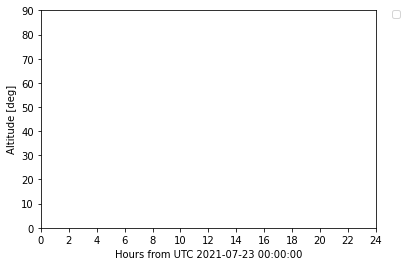

##################
## KEY EXPORTED ##
##################



In [24]:
previewKey(sortedKey)

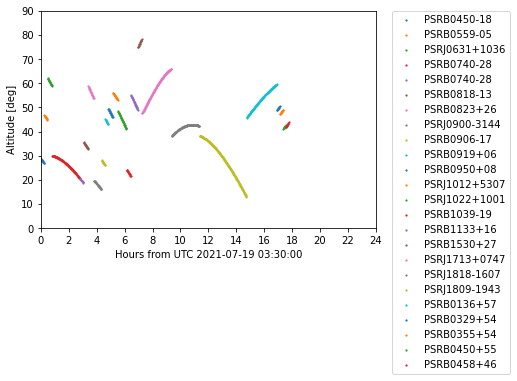

KeyboardInterrupt: Interrupted by user

In [18]:
savedName = "sorted.txt"
saveAsKeyinFile(sortedKey, savedName)
monitoring_txt(savedName)